In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re #for extracting place names from titles

import accesses #local file with API certs and database passwords.

#for connecting to databases
import psycopg2
from sqlalchemy import create_engine

import json #for parsing the return from the Google API
import urllib #for passing info to the Google API

In [2]:
# Creat a connection and cursor directly to the database using psycopg2.
conn = psycopg2.connect(host="localhost",database="reddit", user=accesses.db_user, 
                        password=accesses.db_pw)

## Raw Reddit Review and Analysis

In [3]:
c = conn.cursor()
df_raw_reddit = pd.read_sql('select * from raw_reddit', conn, index_col='id')
c.close()

In [4]:
# The API expects no spaces and words concatanated with a '+', which 
# is what this function does.
def convert_address(address):
    converted_address = ''
    try: 
        for word in address.split():
            converted_address += (word + '+')        
        return converted_address[:-1]
    except:
        pass

In [5]:
pat_1 = r'((?:[A-Z]\w+\.*,*\s*\n*){2,})'

places = df_raw_reddit['title'].str.extractall(pat_1).unstack()
# to return the first element, the dataframe
places = places[0]
places = places.rename(columns = {0:'extracted_0',1:'extracted_1'})
places = pd.merge(df_raw_reddit, places, how='left', left_index=True,
                      right_index=True)
places['converted_0'] = places['extracted_0'].apply(convert_address)
places['converted_1'] = places['extracted_1'].apply(convert_address)
places = places.replace({None:np.nan})

### Now we can pull the Geocoded locations from the database

In [6]:
# During testing, multiple runs introduced several duplicates.  Since this
# class focuses on Python, I handled the duplicates here rather than in 
# the database itself.

c = conn.cursor()
# select all rows from the geocoded_addresses table
df_geocoded = pd.read_sql('select * from geocoded_addresses', conn)
# get original length
print(len(df_geocoded))
# drop all duplicates by ID and set index to the id
df_geocoded.drop_duplicates('id', inplace=True)
df_geocoded.set_index('id', inplace=True)
# print length to see how many we removed
print(len(df_geocoded))
c.close()

33979
33952


In [7]:
def build_geo_dict(df):
    geo_dict_list = []
    error_list = {}
    for row in df.iterrows():
        uid = row[0]
        data = (row[1][0])
        geo_dict = {}
        geo_dict['id'] = uid
        
        try:
            geo_dict['lat'] = data['results'][0]['geometry']['location']['lat']
            geo_dict['lon'] = data['results'][0]['geometry']['location']['lng']
            for component in data['results'][0]['address_components']:
                geo_dict[component['types'][0]] = component['long_name']
            geo_dict_list.append(geo_dict)
        
        except: 
            error_list[uid]=data
        
    return (geo_dict_list, error_list)

In [8]:
results, errors = build_geo_dict(df_geocoded)

### And finally, we can analyze!

In [9]:
sns.set(rc={'figure.figsize':(12,8)})

In [10]:
final_full = pd.DataFrame(results)
final_full.set_index('id', inplace=True)

In [11]:
merged = pd.merge(final_full, places, right_index=True, left_index=True, how='left')
final = merged[['country','administrative_area_level_1', 'score', 'title', 'extracted_0',
                'dt_time','lat', 'lon']]

Our scraper got some dates from 2016, so we are going to limit it to 2017 onward only.

In [12]:
final = final[final['dt_time'] > dt.datetime(2017,1,1)]

## Wordcloud

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [14]:
text = final['extracted_0'].values

In [15]:
text = " ".join(title for title in final['extracted_0'])

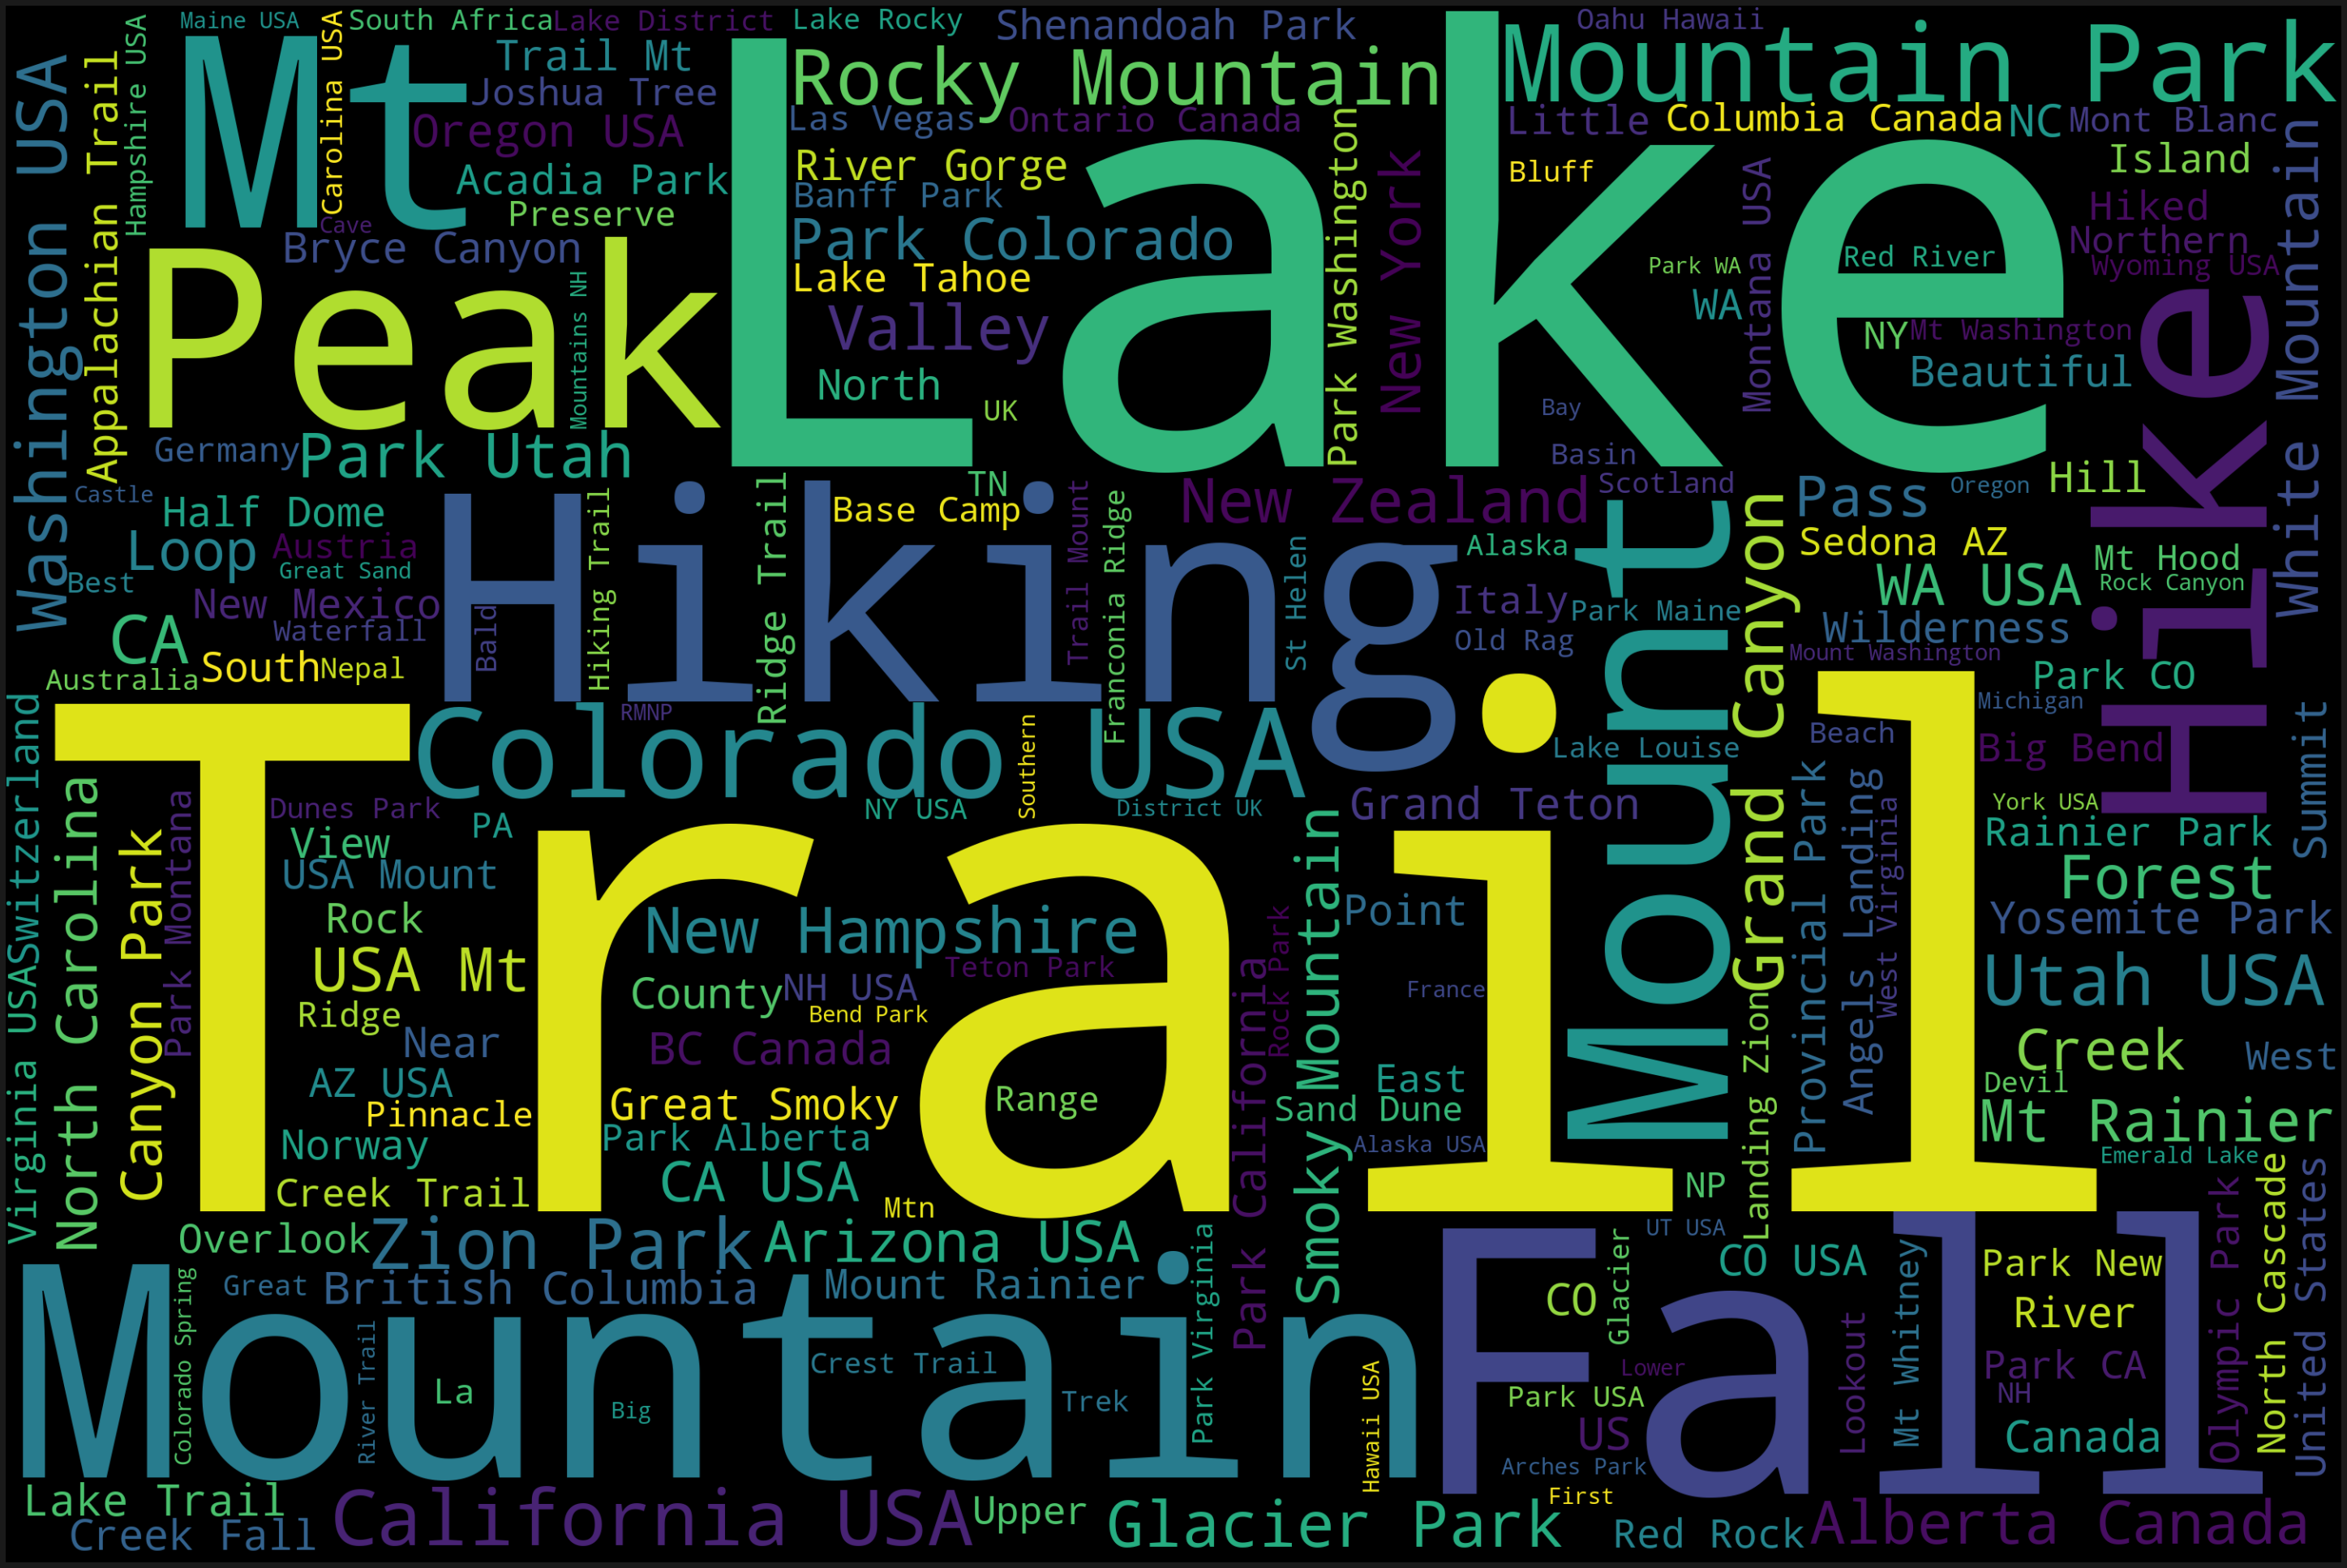

In [16]:
stopwords = set(STOPWORDS)
stopwords.update(["national", "state"])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stopwords).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Let's look at the score, which shows how many "upvotes" a particular submission received.  This is a proxy for how popular each submission was.

There is one exceptionally high outlier from a plea for a missing hiker.  since this outlier is over three times further out than any other point, we are going to remove it.

In [17]:
final.describe()

,score,lat,lon
count,30898.000000,30898.000000,30898.000000
mean,98.010810,37.943294,-77.467856
std,372.979921,16.160806,63.533325
min,0.000000,-82.862752,-166.808055
25%,2.000000,36.050088,-116.084567
50%,11.000000,39.601392,-102.339691
75%,40.000000,45.427110,-74.005973
max,30477.000000,78.223172,178.369200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a34b23470>]],
      dtype=object)

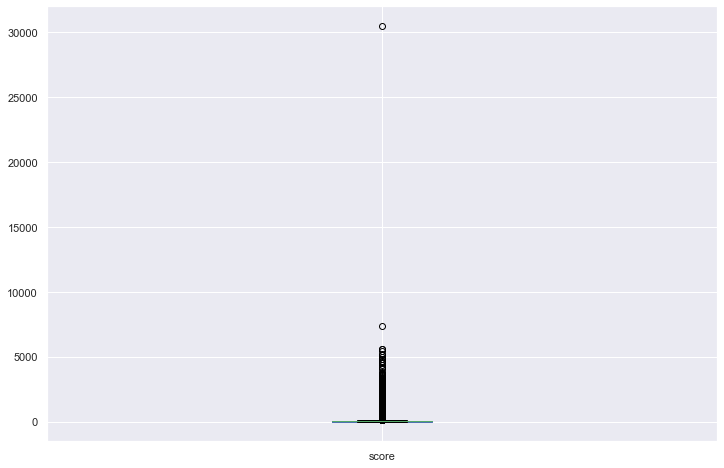

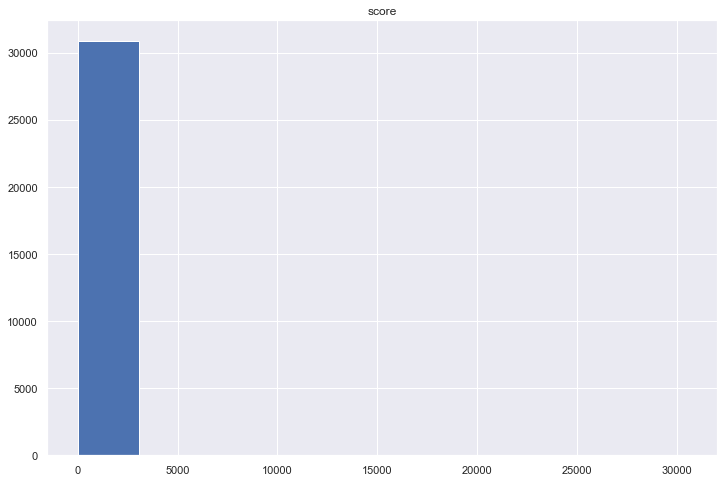

In [18]:
final.boxplot('score')
final.hist('score')

In [19]:
final[final['score'] >10000]
#final.drop(26480, inplace=True)
final.drop(9492, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a352ecd30>]],
      dtype=object)

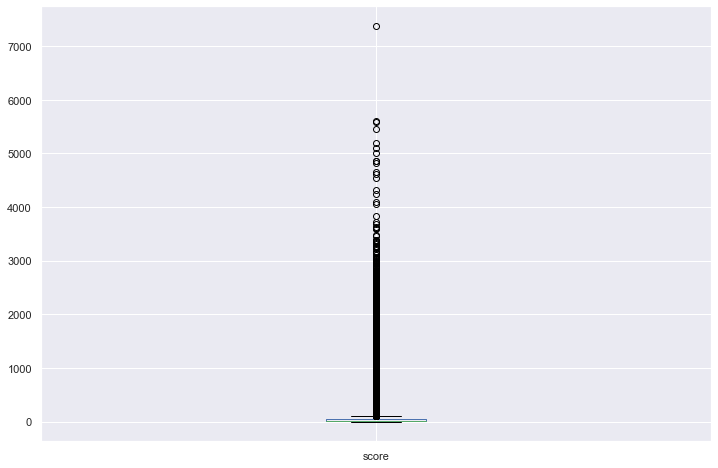

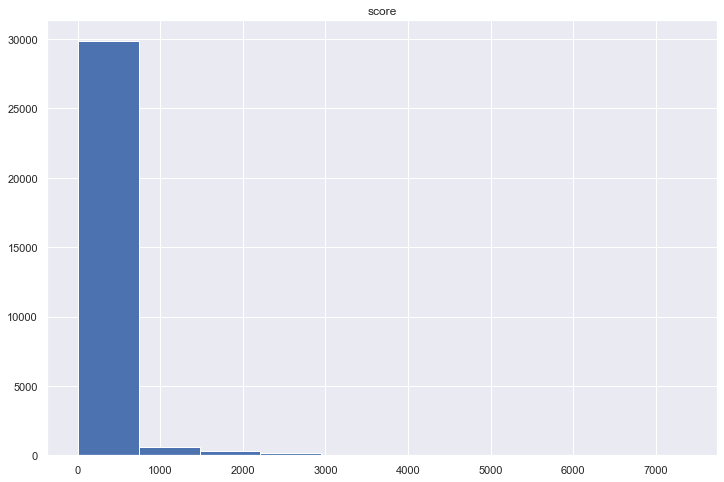

In [20]:
final.boxplot('score')
final.hist('score')

There numerous posts that only get a few upvotes while a small number can get thousands.  The median upvote score is only 11, while the average is 97, showing a significant right skew.  Maybe we should plot the most popular submissions to see if there are any differences.

### A look at the temporal aspect...

In [21]:
final['Year of Submission'] = final['dt_time'].dt.year
final['Month of Submission'] = final['dt_time'].dt.month
final['Day of Submission'] = final['dt_time'].dt.date

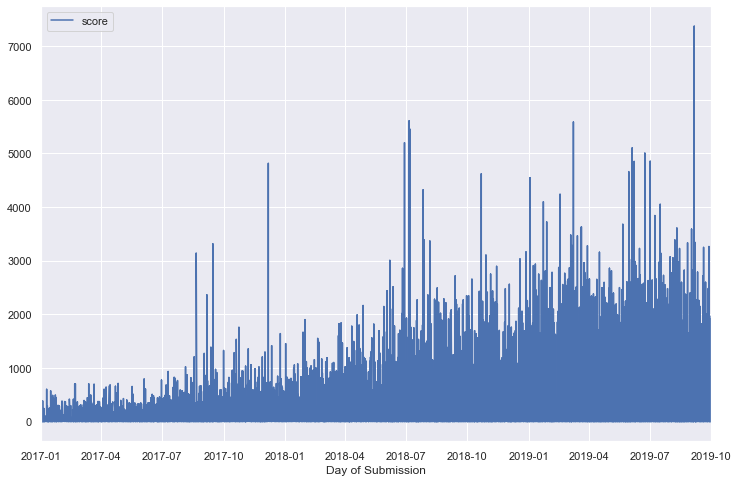

In [22]:
final.plot(x='Day of Submission', y='score', figsize=(12,8))

Text(0.5, 1.0, 'Count of Submissions by Month, Colored by Year')

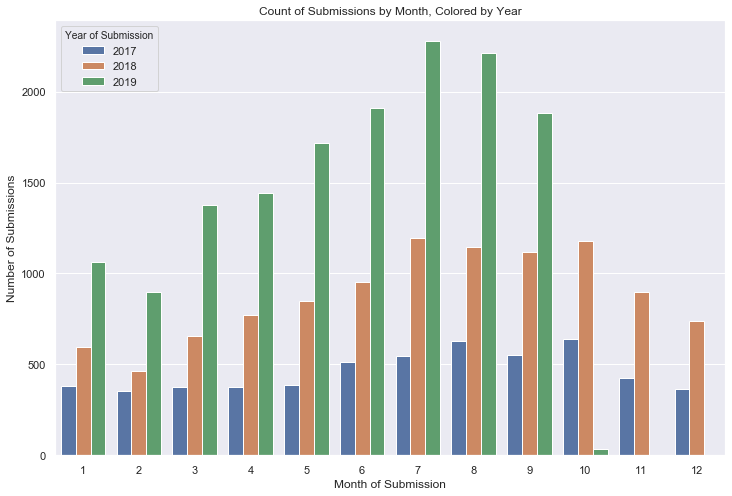

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x='Month of Submission',  hue='Year of Submission', data=final)
plt.ylabel('Number of Submissions')
plt.title('Count of Submissions by Month, Colored by Year')


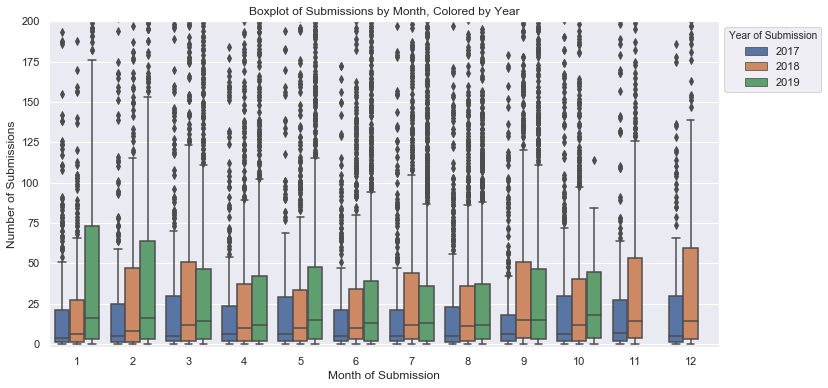

In [24]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Month of Submission', y='score',  hue='Year of Submission', data=final)
plt.ylim(bottom=-2)
plt.ylim(top=200)
plt.ylabel('Number of Submissions')
plt.title('Boxplot of Submissions by Month, Colored by Year')
ax.get_legend().set_bbox_to_anchor((1, 1))

In [25]:
season_dict = {1:'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 
               6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
              11: 'Fall', 12: 'Winter'}

final['Season'] = final['Month of Submission'].map(season_dict)

season_color = {'Winter':'blue', 'Spring':'green', 'Summer':'yellow','Fall':'brown'}
final['season_color'] = final['Season'].map(season_color)

Text(0.5, 1.0, 'Count of Submissions by Month, Colored by Season')

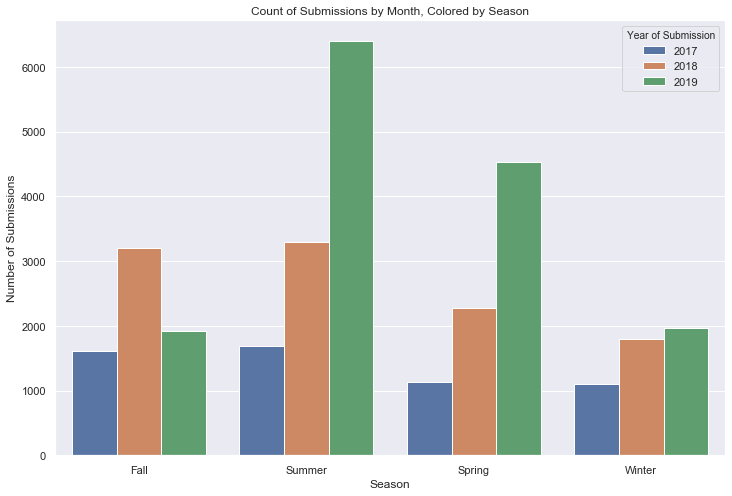

In [26]:
sns.countplot(hue='Year of Submission',  x='Season', data=final)
plt.ylabel('Number of Submissions')
plt.title('Count of Submissions by Month, Colored by Season')

### What places are mentioned in the submissions?

In [27]:
us_totals = pd.DataFrame()
us = final[final['country']=='United States']

us_totals['count'] = us.groupby('administrative_area_level_1').count()['country']
us_totals['score_total'] = us.groupby('administrative_area_level_1').sum()['score']
us_totals['country'] = 'United States'
us_totals['color'] = 'blue'


In [28]:
rest_totals = pd.DataFrame()
rest = final[~final.country.isin(['United States'])]

rest_totals['count'] = rest.groupby('country').count()['score']
rest_totals['score_total'] = rest.groupby('country').sum()['score']

rest_totals['country'] = 'Other'
rest_totals['color'] = 'grey'

In [29]:
all_totals = us_totals.append(rest_totals)

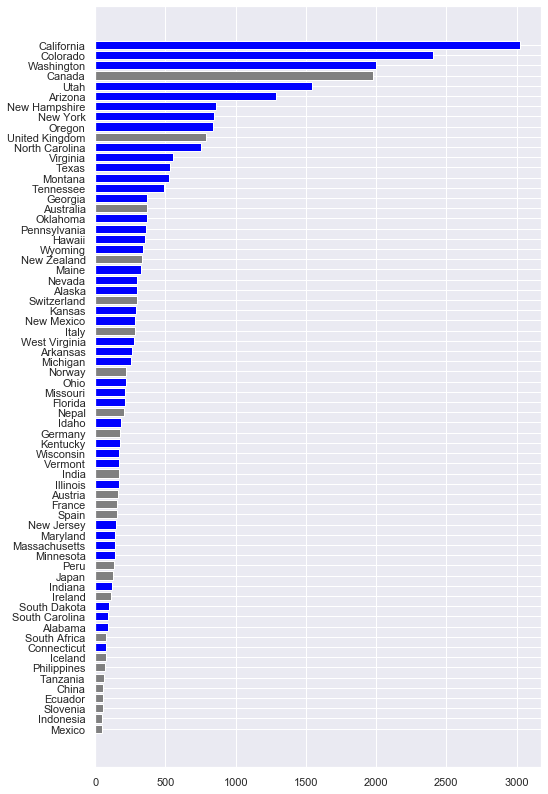

In [30]:
all_totals = all_totals.sort_values('count',ascending=True)
all_totals_subset = all_totals[all_totals['count'] > 50]
f, ax = plt.subplots(figsize=(8,14))
plt.barh(y=all_totals_subset.index, width=all_totals_subset['count'], 
         color=all_totals_subset['color'])
plt.show()

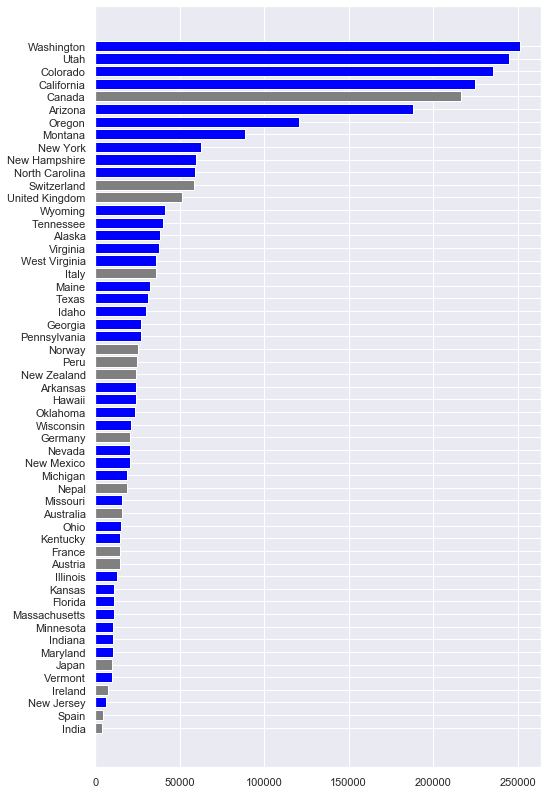

In [31]:
all_totals = all_totals.sort_values('score_total',ascending=True)
all_totals_subset = all_totals[all_totals['count'] > 100]
f, ax = plt.subplots(figsize=(8,14))
plt.barh(y=all_totals_subset.index, width=all_totals_subset['score_total'], 
         color=all_totals_subset['color'])
plt.show()

### Plotting places from the submissions

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [33]:
world_gdf = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
world_gdf = world_gdf[world_gdf['NAME'] != 'Antarctica']

In [34]:
# Lets normalize the 'score' fields so we can use it to plot size.
final['normed_score'] = 150*(final['score']-min(final['score']))/(max(final['score'])-min(final['score']))
sites = gpd.GeoDataFrame(final, geometry=[Point(x, y) 
                                           for x, y in zip(final['lon'],final['lat'])])


Now, lets take our latitudes and longitudes from the GoogleMap API and turn them into points using Geopandas "Point" function.  This will let us layer the points on our basemap from before.

(-197.99999999999991, 198.00000000000003, -91.28986091564178, 91.9638131086497)

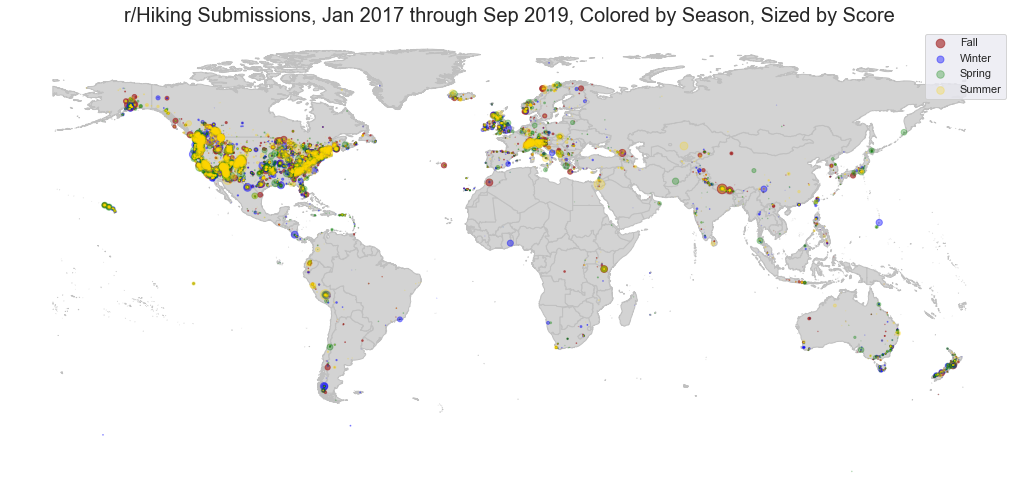

In [35]:
ax = world_gdf.plot(color='lightgrey', edgecolor='silver', figsize=(18,10))

sites[sites['Season']=='Fall'].plot(ax=ax, marker='o', color='brown', markersize='normed_score', 
                                    label='Fall',alpha=.65)
sites[sites['Season']=='Winter'].plot(ax=ax, marker='o', color='blue', markersize='normed_score', 
                                      label='Winter',alpha=.4)
sites[sites['Season']=='Spring'].plot(ax=ax, marker='o', color='green', markersize='normed_score',
                                      label='Spring',alpha=.3)
sites[sites['Season']=='Summer'].plot(ax=ax, marker='o', color='gold', markersize='normed_score', 
                                      label='Summer',alpha=.25)
ax.set_aspect('equal')
ax.legend()
ax.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
ax.axis('off')

Great!  We can finally see where our most popular photos were taken!  As suspected, there is a huge bias to the United States.



## Can we plot just the Continental United States?

In [36]:
final['normed_score'] = 800*(final['score']-min(final['score']))/(max(final['score'])-min(final['score']))
sites = gpd.GeoDataFrame(final, geometry=[Point(x, y) 
                                           for x, y in zip(final['lon'],final['lat'])])

In [37]:
states_provinces_gdf = gpd.read_file('ne_10m_admin_1_states_provinces_lakes/ne_10m_admin_1_states_provinces_lakes.shp')
states_gdf = states_provinces_gdf[states_provinces_gdf.admin.isin(['United States of America'])]
cont_us = states_gdf[~states_gdf.name.isin(['Hawaii', 'Alaska'])]

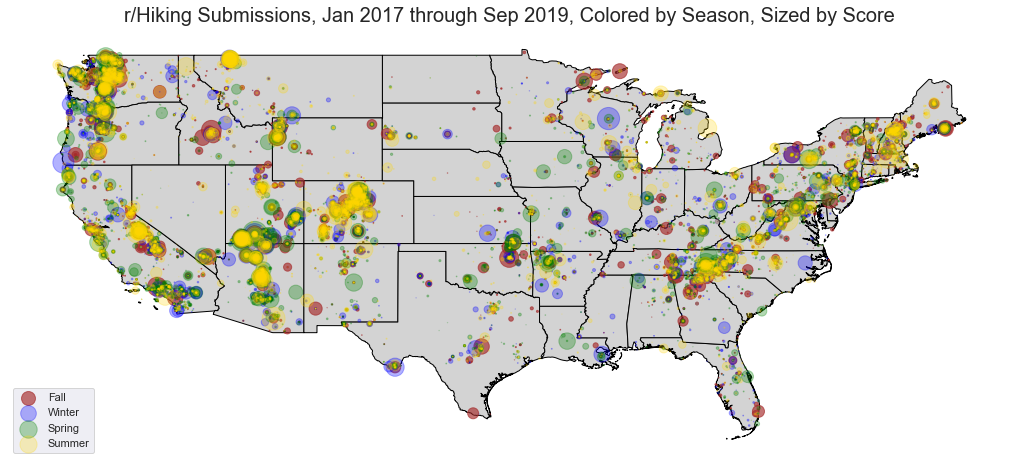

In [38]:
cont_us_map = cont_us.plot(color='lightgrey', edgecolor='black', figsize=(18,12))
cont_us_map.set_aspect('equal')
us_sites = sites[(sites['country'] == 'United States')]
cont_us_sites = us_sites[~us_sites.administrative_area_level_1.isin(['Hawaii', 'Alaska']) &
                        (us_sites['lat'] < 60)]
cont_us_sites[cont_us_sites['Season']=='Fall'].plot(ax=cont_us_map, label='Fall',marker='o',
                                                    markersize='normed_score', color='brown', alpha=.65)
cont_us_sites[cont_us_sites['Season']=='Winter'].plot(ax=cont_us_map, label='Winter', marker='o', 
                                                      markersize='normed_score', color='blue', alpha=.3)
cont_us_sites[cont_us_sites['Season']=='Spring'].plot(ax=cont_us_map, label='Spring', marker='o', 
                                                     markersize='normed_score', color='green', alpha=.3)
cont_us_sites[cont_us_sites['Season']=='Summer'].plot(ax=cont_us_map, label='Summer', marker='o', 
                                                      markersize='normed_score', color='gold', alpha=.25)

cont_us_map.axis('off')
cont_us_map.legend()
cont_us_map.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
plt.show()

## Choropleth Maps

We can take a look at just the US with a choropleth map as well.  We'll make two; one for count of submissions and another for total score.

(-127.62674177639992, -63.9997819315999, 23.30120060887725, 50.61084143157933)

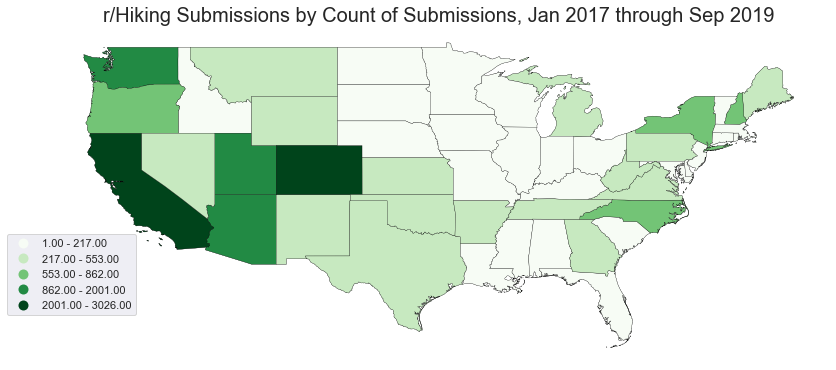

In [39]:
merged = pd.merge(cont_us, us_totals,  how='right', right_index=True, 
                  left_on='name')

ax = cont_us.plot(edgecolor='black', linewidth = .15, color='silver', figsize=(14,10))
states_to_plot = merged[['name','count','geometry']]
states_to_plot = states_to_plot[~states_to_plot['name'].isin(['Hawaii', 'Alaska'])]
states_to_plot.plot(ax=ax, column='count', cmap='Greens', scheme='fisher_jenks', k=5,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Count of Submissions, Jan 2017 through Sep 2019', fontsize=20)
ax.axis('off')

(-127.62674177639992, -63.9997819315999, 23.30120060887725, 50.61084143157933)

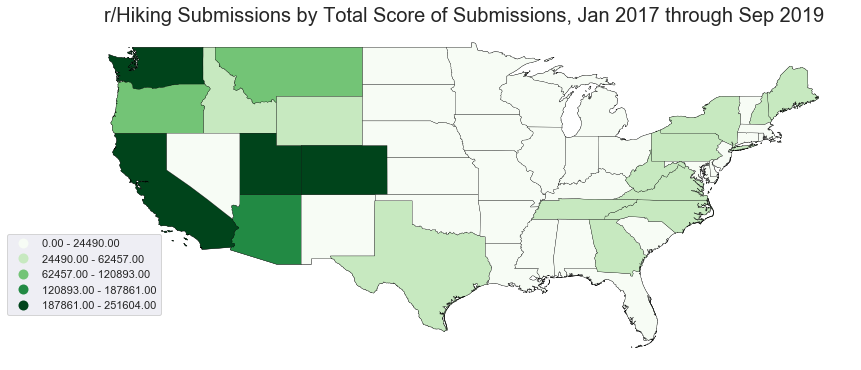

In [40]:
merged = pd.merge(cont_us, us_totals,  how='right', right_index=True, 
                  left_on='name')

ax = cont_us.plot(edgecolor='black', linewidth = .45, color='silver', figsize=(14,10))
states_to_plot = merged[['name','score_total','geometry']]
states_to_plot = states_to_plot[~states_to_plot['name'].isin(['Hawaii', 'Alaska'])]
states_to_plot.plot(ax=ax, column='score_total', cmap='Greens', scheme='fisher_jenks', k=5,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Total Score of Submissions, Jan 2017 through Sep 2019', fontsize=20)
ax.axis('off')

## Heat Map of the World!

In [41]:
world_gdf_for_merge = world_gdf[['ADMIN','geometry']]
world_gdf_for_merge = world_gdf_for_merge.rename(columns={'ADMIN':'name'})
states_gdf_for_merge = states_gdf[['name','geometry']]
combo_gdf = world_gdf_for_merge.append(states_gdf_for_merge)

merged = pd.merge(combo_gdf, all_totals,  how='right', right_index=True, 
                  left_on='name')

Text(0.5, 1, 'r/Hiking Submissions by Count of Submissions, Jan 2017 through Sep 2019')

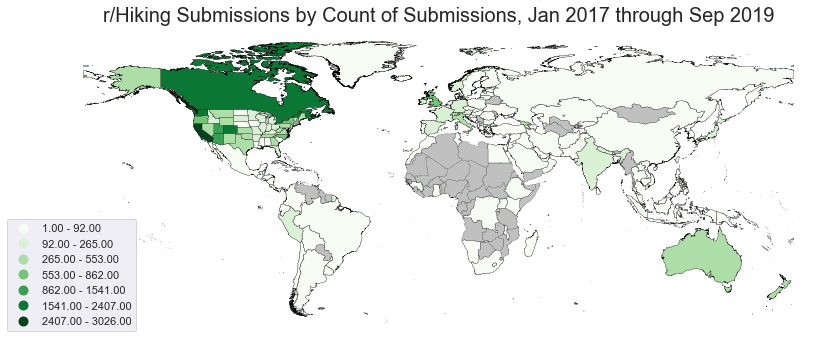

In [42]:
ax = combo_gdf.plot(edgecolor='black', linewidth = .15, color='silver', figsize=(14,10))
merged.plot(ax=ax, column='count', cmap='Greens', scheme='fisher_jenks', k=7,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Count of Submissions, Jan 2017 through Sep 2019', fontsize=20)

Text(0.5, 1, 'r/Hiking Submissions by Total Score of Submissions, Jan 2017 through Sep 2019')

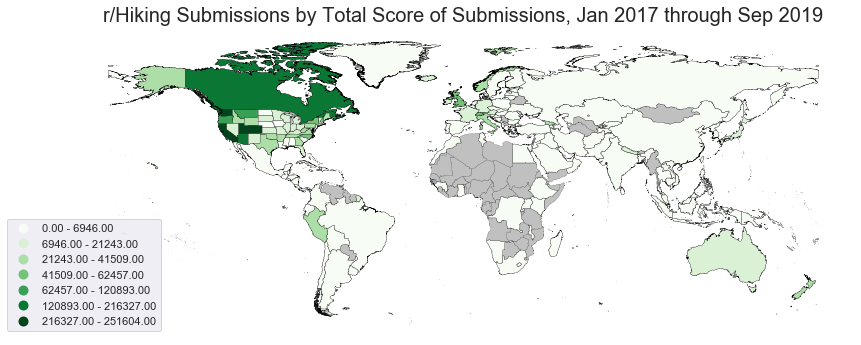

In [43]:
ax = combo_gdf.plot(edgecolor='black', linewidth = .15, color='silver', figsize=(14,10))
merged.plot(ax=ax, column='score_total', cmap='Greens', scheme='fisher_jenks', k=7,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Total Score of Submissions, Jan 2017 through Sep 2019', fontsize=20)

## Key Findings And Conclusions

Overall, the r/Hiking subreddit is increasing in popularity with more submissions year over year since 2017, and more upvotes as well.  As expected, there is a sginificant bias in the United States, and to a lesser extent Canada.  This is to be expexted on an English lanaguage sub-reddit, but the scale of it was not expected.  

For geogrpahic trends in the US, there is a high concentration across California, the state with the highest number of submissions and the third highest total score of upvotes.  However, Washington was remarkable for having the highest total score while ranking third on number of submissions.  This suggests that submissions featuring hiking destinations in Washington on average score higher than submissions from California.  There are also hotspots near concentrations of national parks and mountian ranges, as well as along coasts.

I analyzed seasonality to look for trends in both time and space for the four different seasons.  Overall, the summer and spring are more popular times for submissions.  However, I did not observe any strong trends spatially based on season.  A more detailed analysis of state by state totals and averages across the four season could identify unobserved trends.

In conclusion, if you want a high scoring post on Reddit's r/Hiking, your best bet is to fly out to Washington and get some excellent photos of the beautiful scenery.
